In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

### Data Preprocessing

In [2]:
directory = 'source/topBonds.csv'

# read sql
df = pd.read_csv(directory, parse_dates=['TrdExctnDtEOM'])

# select columns
df = df[['CusipId', 'TrdExctnDtEOM', 'TD_Volume', 'Coupon', 'RatingClass', 'MaturityBand', 'R']]

# rename columns
df.columns = ['Cusip', 'Date', 'Volume', 'Coupon', 'RatingClass', 'MaturityBand', 'R']

# sort values to CusipId-Date
df = df.sort_values(by=['Cusip', 'Date'])

### Quantile Filtering and Outlier Visualization

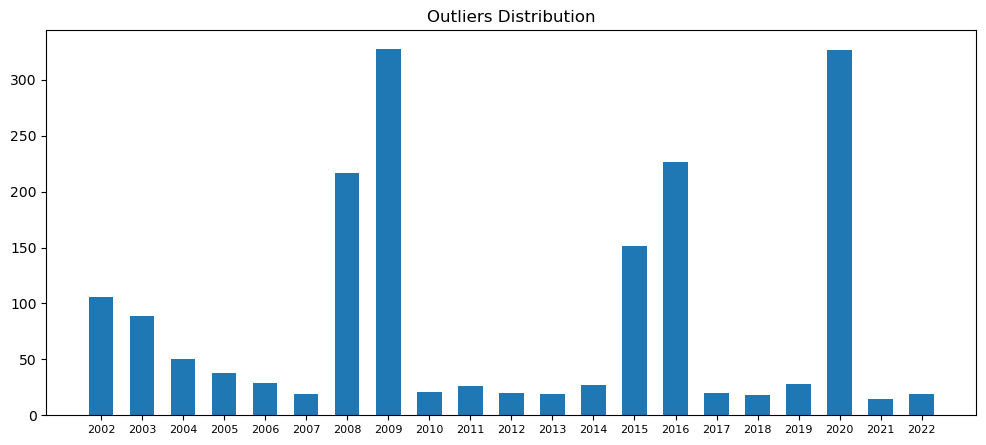

In [3]:
# identify values > 99.5th and < 0.05th percentiles
df['quantiles'] = pd.qcut(df.R, np.linspace(0, 1, 201), labels=np.linspace(0, 1, 200)).astype(float)

# mark them as outliers
df['outliers'] = np.where((df['quantiles'] > 0.995) | (df['quantiles'] < 0.005), 1, 0)

# visualize outliers per year
df['Year'] = df['Date'].dt.year
df_g = df.groupby('Year')['outliers'].sum().reset_index()
plt.figure(figsize=(12, 5))
plt.title('Outliers Distribution')
plt.bar(df_g['Year'], df_g['outliers'], width = 0.6)
plt.xticks([i for i in range(2002, 2023)], fontsize=8)
plt.show()

In [4]:
# this filter requires for the bond to be present in the full duration of the formation period
df['R'] = np.where(df['outliers'] == 0, df['R'], np.nan)

### Portfolio Analysis

In [5]:
# log returns
df['LogR'] = np.log(1 + df['R'])

# formation period in months
J = 2

# sort on Cusip, Date
df_ = df[['Cusip', 'Date', 'R', 'LogR']].sort_values(['Cusip', 'Date']).set_index('Date')

# cumulative sum of returns given the formation period
cumulative_r = df_.groupby(['Cusip'])['LogR'].rolling(J, min_periods=J).sum().reset_index()
cumulative_r = cumulative_r.rename(columns = {'LogR': 'SumLogR'})
cumulative_r['CumReturns'] = np.exp(cumulative_r['SumLogR'])-1

# momentum ranking
r = 10 
cumulative_r = cumulative_r.dropna(axis=0, subset=['CumReturns'])
cumulative_r['MomentumRanking'] = cumulative_r.groupby('Date')['CumReturns'].transform(lambda x: pd.qcut(x, r, labels=False))
cumulative_r['MomentumRanking'] = 1 + cumulative_r['MomentumRanking'].astype(int)

# mean of cumulative returns for the momentum ranking
cumulative_r.groupby('MomentumRanking')['CumReturns'].mean()

MomentumRanking
1    -0.045891
2    -0.015508
3    -0.006407
4    -0.000206
5     0.005273
6     0.010866
7     0.016929
8     0.024557
9     0.036259
10    0.075049
Name: CumReturns, dtype: float64

In [6]:
# holding period in months
K = 3
cumulative_r['FormationDate'] = cumulative_r['Date']

# holding period date ranges
cumulative_r['HoldingDate1'], cumulative_r['HoldingDate2'] = cumulative_r['Date'] + MonthBegin(1), cumulative_r['Date'] + MonthEnd(K)
cumulative_r = cumulative_r[['Cusip', 'FormationDate', 'MomentumRanking', 'HoldingDate1', 'HoldingDate2']]

# join momentum ranking and returns
portfolios = pd.merge(df[['Cusip', 'Date', 'R']], cumulative_r, on=['Cusip'], how='inner')
portfolios = portfolios[(portfolios['HoldingDate1'] <= portfolios['Date']) & (portfolios['Date'] <= portfolios['HoldingDate2'])]
portfolios = portfolios[['Cusip', 'FormationDate', 'MomentumRanking', 'HoldingDate1', 'HoldingDate2', 'Date', 'R']]

agg_portfolios = portfolios.groupby(['Date', 'MomentumRanking', 'FormationDate'])['R'].mean().reset_index()

# skip first two years
agg_portfolios = agg_portfolios.loc[agg_portfolios.Date.dt.year >= agg_portfolios['Date'].dt.year.min() + 2]
agg_portfolios = agg_portfolios.sort_values(by=['Date', 'MomentumRanking'])

# calculate mean and std on returns
eq_weighted_return = agg_portfolios.groupby(['Date', 'MomentumRanking'])['R'].mean().reset_index()
eq_weighted_std = agg_portfolios.groupby(['Date', 'MomentumRanking'])['R'].std().reset_index()

# rename columns
eq_weighted_return = eq_weighted_return.rename(columns={'R': 'EqualWeightedReturn'})
eq_weighted_std = eq_weighted_std.rename(columns={'R': 'EqualWeightedStd'})

# unify equal weighted return metrics
eq_weighted_return_df = pd.merge(eq_weighted_return, eq_weighted_std, on=['Date', 'MomentumRanking'], how='inner')
eq_weighted_return_df = eq_weighted_return_df.sort_values(by=['MomentumRanking', 'Date'])

# portfolio summary
eq_weighted_return_df.groupby(['MomentumRanking'])['EqualWeightedReturn'].describe()[['count','mean', 'std']].reset_index()

,MomentumRanking,count,mean,std
0,1,225.0,0.004708,0.029438
1,2,225.0,0.003867,0.020880
2,3,225.0,0.003531,0.018848
3,4,225.0,0.003816,0.017434
4,5,225.0,0.003907,0.017171
5,6,225.0,0.003783,0.016198
6,7,225.0,0.003899,0.015867
7,8,225.0,0.004217,0.016571
8,9,225.0,0.004299,0.018468
9,10,225.0,0.007548,0.022990


In [7]:
# transpose equal weighted returns
eq_weighted_return_tdf = eq_weighted_return_df.pivot(index='Date', columns='MomentumRanking', values='EqualWeightedReturn') 

# modify portfolio naming
eq_weighted_return_tdf = eq_weighted_return_tdf.add_prefix('Portfolio-') 

# identify losers and winners
eq_weighted_return_tdf = eq_weighted_return_tdf.rename(columns={'Portfolio-1': 'Losers', 'Portfolio-10': 'Winners'})

# calculate long-short strategy
eq_weighted_return_tdf['LongShort'] = eq_weighted_return_tdf.Winners - eq_weighted_return_tdf.Losers

# portfolio summary
eq_weighted_return_tdf.head()

MomentumRanking,Losers,Portfolio-2,Portfolio-3,Portfolio-4,Portfolio-5,Portfolio-6,Portfolio-7,Portfolio-8,Portfolio-9,Winners,LongShort
Date,,,,,,,,,,,
2004-01-31,0.017337,0.008876,0.008164,0.010059,0.008532,0.009334,0.008516,0.009553,0.001011,0.013885,-0.003451
2004-02-29,0.024396,0.009552,0.011929,0.012367,0.010196,0.014953,0.007206,0.006877,-0.002167,-0.015459,-0.039855
2004-03-31,0.012889,0.008503,0.005415,0.004717,0.008666,0.012064,0.010361,0.001776,0.006103,0.010994,-0.001895
2004-04-30,0.000778,-0.009043,-0.004605,-0.024574,-0.026039,-0.027708,-0.035648,-0.028112,-0.030229,-0.007196,-0.007974
2004-05-31,-0.006677,-0.021572,-0.009507,-0.010724,-0.010178,-0.006325,-0.007804,-0.013908,-0.012469,-0.002267,0.004410


In [8]:
# compute cumulative returns
eq_weighted_return_tdf['CumulativeReturns_Winners'] = (1 + eq_weighted_return_tdf.Winners).cumprod() - 1 
eq_weighted_return_tdf['CumulativeReturns_Losers'] = (1 + eq_weighted_return_tdf.Losers).cumprod() - 1
eq_weighted_return_tdf['CumulativeReturns_LongShort'] = (1 + eq_weighted_return_tdf.LongShort).cumprod() - 1

momentum_mean = eq_weighted_return_tdf[['Winners', 'Losers', 'LongShort']].mean().to_frame()
momentum_mean = momentum_mean.rename(columns={0: 'mean'}).reset_index()
momentum_mean

,MomentumRanking,mean
0,Winners,0.007548
1,Losers,0.004708
2,LongShort,0.002840


In [9]:
# t-statistics for winners, losers, long-short
t_losers = pd.Series(stats.ttest_1samp(eq_weighted_return_tdf['Losers'], 0.0)).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(eq_weighted_return_tdf['Winners'], 0.0)).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(eq_weighted_return_tdf['LongShort'], 0.0)).to_frame().T

# build structures
t_losers['MomentumRanking'] = 'Losers'
t_winners['MomentumRanking'] = 'Winners'
t_long_short['MomentumRanking'] = 'LongShort'

# combine statistics
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0: 't-stat', 1: 'p-value'}) 
momentum_output = pd.merge(momentum_mean, t_output, on=['MomentumRanking'], how='inner')

# format output
momentum_output['mean'] = momentum_output['mean'].map('{:.2%}'.format) 
momentum_output['t-stat'] = momentum_output['t-stat'].map('{:.2f}'.format) 
momentum_output['p-value'] = momentum_output['p-value'].map('{:.2f}'.format) 
print('Momentum Strategy Summary:\n\n', momentum_output)

Momentum Strategy Summary:

   MomentumRanking   mean t-stat p-value
0         Winners  0.75%   4.92    0.00
1          Losers  0.47%   2.40    0.02
2       LongShort  0.28%   2.08    0.04


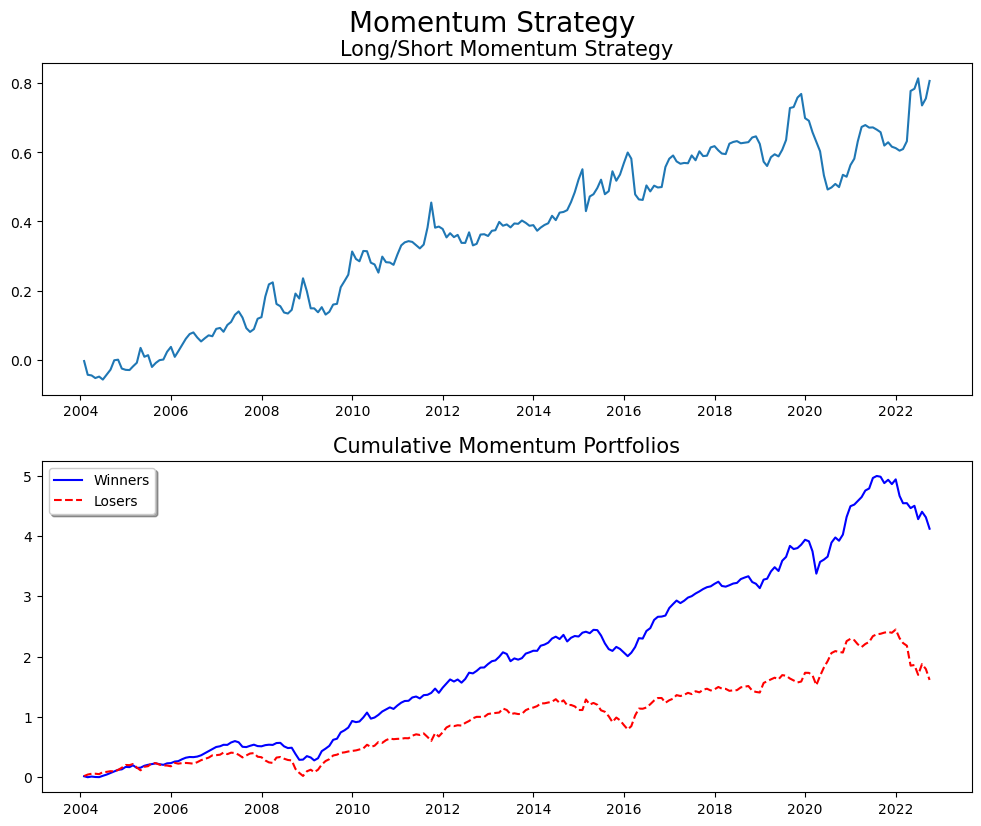

In [10]:
# visualization of cumulative strategy, winners, losers
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 
ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(eq_weighted_return_tdf['CumulativeReturns_LongShort']) 
ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(eq_weighted_return_tdf['CumulativeReturns_Winners'], 'b-', eq_weighted_return_tdf['CumulativeReturns_Losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)
plt.subplots_adjust(top=0.92, hspace=0.2)